# Mass Regression Notebook
In this notebook we will explore the first concepts of how to apply a neural network or deep learning to the 2-D mass plane.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot as ur
import awkward as ak

print('Numpy version: {}'.format(np.__version__))
print('Uproot version: {}'.format(ur.__version__))
print('Awkward version: {}'.format(ak.__version__))

Numpy version: 1.23.1
Uproot version: 4.3.3
Awkward version: 1.8.0


## Uproot files

In [2]:
rootfile_prefix = '/fast_scratch_1/atlas_images/XhhNTuple/'
rfile = 'user.zhenw.29137978._000001.MiniNTuple.root'

In [3]:
uprooted = ur.open(rootfile_prefix+rfile)
uprooted.keys()

['XhhMiniNtuple;1',
 'cutflow_XhhMiniNtuple;1',
 'cutflow_weighted_XhhMiniNtuple;1',
 'MetaData_EventCount_XhhMiniNtuple;1']

In [4]:
MNTuple = uprooted['XhhMiniNtuple']
# events.arrays(["px1", "py1", "pz1"])
MNTuple.show(name_width=32,
            interpretation_width=30)

name                             | typename                 | interpretation                
---------------------------------+--------------------------+-------------------------------
runNumber                        | int32_t                  | AsDtype('>i4')
eventNumber                      | int64_t                  | AsDtype('>i8')
lumiBlock                        | int32_t                  | AsDtype('>i4')
coreFlags                        | uint32_t                 | AsDtype('>u4')
bcid                             | int32_t                  | AsDtype('>i4')
mcEventNumber                    | int32_t                  | AsDtype('>i4')
mcChannelNumber                  | int32_t                  | AsDtype('>i4')
mcEventWeight                    | float                    | AsDtype('>f4')
NPV                              | int32_t                  | AsDtype('>i4')
actualInteractionsPerCrossing    | float                    | AsDtype('>f4')
averageInteractionsPerCrossing   | float    

## Load Utils

In [5]:
import os
import sys
cwd = os.getcwd()
path_head, path_tail = os.path.split(cwd)
sys.path.append(path_head+'/utils')
from ml_utils import dict_from_tree, DeltaR
from time import perf_counter as cput

## Load Data

In [6]:
branches = ['boosted_nGoodJets', "nboostedJets", "boostedJets_m",
            "boostedJets_pt", "boostedJets_phi", "boostedJets_eta",
           "truth_mHH", 'truthjet_antikt10_pt', 'truthjet_antikt10_eta',
           'truthjet_antikt10_phi', 'truthjet_antikt10_m']
np_branches = ['eventNumber']

In [7]:
t0 = cput()
hh4b_dict = dict_from_tree(MNTuple, branches, np_branches)
t1 = cput()
method_1_time = t1 - t0
print('Time to load arrays: {:8.4f} (s)'.format(method_1_time))

nEvents = len(hh4b_dict['eventNumber'])
print('{} Events'.format(nEvents))

Time to load arrays:   1.6411 (s)
339978 Events


In [8]:
gt_twoJets = np.zeros(nEvents, dtype=bool)
t0 = cput()
for i in range(nEvents):
    boostedJets_pt = ak.to_numpy(hh4b_dict['boostedJets_pt'][i])
    
    if len(boostedJets_pt) >=2:
        gt_twoJets[i] = True

n2jets = np.count_nonzero(gt_twoJets)
print(n2jets)
t1 = cput()
print(t1 - t0)

95892
29.207738445024006


# Fill arrays with inputs

In [20]:
list_indices = np.arange(nEvents)
# evt_idx = np.full(shape=(n2jets,), fill_value=-1)
evt_idx = np.ndarray.copy(list_indices[gt_twoJets])

for jk in range(20):
    evt = evt_idx[jk]
    nboosted = len(ak.to_numpy(hh4b_dict['boostedJets_pt'][evt]))
    print('Event with matched jets: {}'.format(evt_idx[jk]))
    print('Number of boosted jets:   {}'.format(nboosted))

Event with matched jets: 1
Number of boosted jets:   2
Event with matched jets: 3
Number of boosted jets:   2
Event with matched jets: 9
Number of boosted jets:   2
Event with matched jets: 14
Number of boosted jets:   2
Event with matched jets: 20
Number of boosted jets:   3
Event with matched jets: 27
Number of boosted jets:   2
Event with matched jets: 29
Number of boosted jets:   2
Event with matched jets: 33
Number of boosted jets:   2
Event with matched jets: 34
Number of boosted jets:   2
Event with matched jets: 36
Number of boosted jets:   2
Event with matched jets: 50
Number of boosted jets:   2
Event with matched jets: 51
Number of boosted jets:   2
Event with matched jets: 54
Number of boosted jets:   2
Event with matched jets: 55
Number of boosted jets:   2
Event with matched jets: 56
Number of boosted jets:   2
Event with matched jets: 58
Number of boosted jets:   2
Event with matched jets: 62
Number of boosted jets:   2
Event with matched jets: 67
Number of boosted jets:

In [21]:
t0 = cput()
matched_jets = []
for i, evt in enumerate(evt_idx):
    
    nTruthJets = ak.to_numpy(hh4b_dict['truthjet_antikt10_m'][evt]).shape[0]
    truthJet_coords = np.empty((nTruthJets, 2))
    # this can be vectorized easily (too tired)
    for j in range(nTruthJets):
        truthJet_coords[j,0] = hh4b_dict['truthjet_antikt10_eta'][evt][j]
        truthJet_coords[j,1] = hh4b_dict['truthjet_antikt10_phi'][evt][j]
    
    BoostedJet0_eta = hh4b_dict['boostedJets_eta'][evt][0]
    BoostedJet0_phi = hh4b_dict['boostedJets_phi'][evt][0]
    BoostedJet0_coords = np.array([BoostedJet0_eta, BoostedJet0_phi])
    LeadingJet_DR_arr = DeltaR(truthJet_coords, BoostedJet0_coords)
    # print(LeadingJet_DR_arr)
    LJ_DR = np.min(LeadingJet_DR_arr)
    LJ_DR_idx = np.argmin(LeadingJet_DR_arr)
    
    BoostedJet1_eta = hh4b_dict['boostedJets_eta'][evt][1]
    BoostedJet1_phi = hh4b_dict['boostedJets_phi'][evt][1]
    BoostedJet1_coords = np.array([BoostedJet1_eta, BoostedJet1_phi])
    subLeadingJet_DR_arr = DeltaR(truthJet_coords, BoostedJet1_coords)
    # print(subLeadingJet_DR_arr)
    SLJ_DR = np.min(subLeadingJet_DR_arr)
    SLJ_DR_idx = np.argmin(subLeadingJet_DR_arr)
    
    if SLJ_DR_idx != LJ_DR_idx:
        if LJ_DR < .1 and SLJ_DR < .1:
            matched_jets.append([evt, LJ_DR_idx, SLJ_DR_idx])
    
    # print();print()

t1 = cput()
print('Time to complete jet matching: {:6.3f} (m)'.format((t1 - t0)/60))
print();print()
matched_jets = np.array(matched_jets)

print(matched_jets.shape)

Time to complete jet matching:  1.687 (m)


(94859, 3)


In [22]:
X = np.empty((matched_jets.shape[0],8))
Y = np.empty((matched_jets.shape[0],2))

In [26]:
for i in range(matched_jets.shape[0]):
    arr_slc = matched_jets[i]
    evt = arr_slc[0]
    ld_idx = arr_slc[1]
    sld_idx = arr_slc[2]

    nboosted = len(ak.to_numpy(hh4b_dict['boostedJets_pt'][evt]))
    
    # Leading
    X[i,0] = hh4b_dict['boostedJets_m'][evt][0]
    X[i,1] = hh4b_dict['boostedJets_pt'][evt][0]
    X[i,2] = hh4b_dict['boostedJets_eta'][evt][0]
    X[i,3] = hh4b_dict['boostedJets_phi'][evt][0]
    
    # Sub-Leading
    X[i,4] = hh4b_dict['boostedJets_m'][evt][1]
    X[i,5] = hh4b_dict['boostedJets_pt'][evt][1]
    X[i,6] = hh4b_dict['boostedJets_eta'][evt][1]
    X[i,7] = hh4b_dict['boostedJets_phi'][evt][1]
    
    # Truth Jet
    Y[i,0] = hh4b_dict['truthjet_antikt10_m'][evt][0]
    Y[i,1] = hh4b_dict['truthjet_antikt10_m'][evt][1]

In [13]:
# X = np.random.uniform(low=-1, high=1.0, size=(matched_jets.shape[0],8))
# Y = np.random.uniform(low=-1, high=1.0, size=(matched_jets.shape[0],2))

In [27]:
from ml_mass_regression_models import Dumb_Network
import tensorflow as tf
from tensorflow import keras

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [28]:
test_model = Dumb_Network(num_features=8)
test_model.compile(loss='mse', optimizer=keras.optimizers.Adam(
    learning_rate=.001))
test_model.summary()

2022-08-22 08:02:27.273968: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-08-22 08:02:27.274056: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9672 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5


Model: "dum-dum-net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 8)]               0         
_________________________________________________________________
dense_0 (Dense)              (None, 100)               900       
_________________________________________________________________
activation_0 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_2 (Activation)    (None, 100)               

In [29]:
history = test_model.fit(X,
              Y,
              epochs=10,
              batch_size=1000)

2022-08-22 08:02:43.290335: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
95/95 [==============================] - 5s 3ms/step - loss: 8846184448.0000
Epoch 2/10
95/95 [==============================] - 0s 3ms/step - loss: 1735729536.0000
Epoch 3/10
95/95 [==============================] - 0s 3ms/step - loss: 1310253568.0000
Epoch 4/10
95/95 [==============================] - 0s 3ms/step - loss: 736819008.0000
Epoch 5/10
95/95 [==============================] - 0s 3ms/step - loss: 453055040.0000
Epoch 6/10
95/95 [==============================] - 0s 3ms/step - loss: 438613600.0000
Epoch 7/10
95/95 [==============================] - 0s 3ms/step - loss: 436799680.0000
Epoch 8/10
95/95 [==============================] - 0s 3ms/step - loss: 435512416.0000
Epoch 9/10
95/95 [==============================] - 0s 3ms/step - loss: 433376992.0000
Epoch 10/10
95/95 [==============================] - 0s 3ms/step - loss: 429825664.0000


## Okay model is learning but we need to normalize inputs of course!

## un-normalized

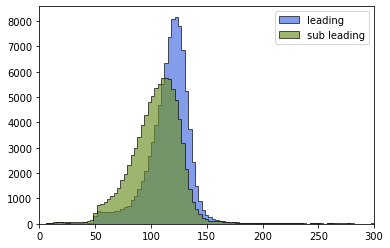

In [37]:
mass_bins = np.linspace(0,300,100,endpoint=True)

plt.hist(X[:,0], bins=mass_bins, label='leading', alpha=.65, color='royalblue',
        edgecolor='black', histtype='stepfilled')
plt.hist(X[:,4], bins=mass_bins, label='sub leading', alpha=.65,
         color='olivedrab', edgecolor='black', histtype='stepfilled')
plt.xlim(np.min(mass_bins), np.max(mass_bins))
plt.legend()
plt.show()

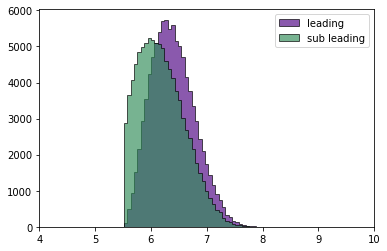

In [44]:
logPt_bins = np.linspace(4,10,100,endpoint=True)

plt.hist(np.log(X[:,1]), bins=logPt_bins, label='leading', alpha=.65, color='indigo',
        edgecolor='black', histtype='stepfilled')
plt.hist(np.log(X[:,5]), bins=logPt_bins, label='sub leading', alpha=.65,
         color='seagreen', edgecolor='black', histtype='stepfilled')
plt.xlim(4, np.max(logPt_bins))
plt.legend()
plt.show()

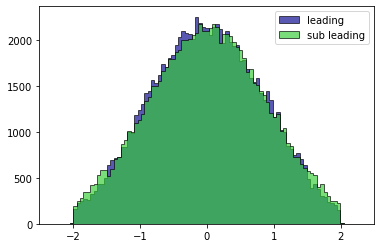

In [47]:
eta_bins = np.linspace(-2.5,2.5,100,endpoint=True)

plt.hist(X[:,2], bins=eta_bins, label='leading', alpha=.65, color='darkblue',
        edgecolor='black', histtype='stepfilled')
plt.hist(X[:,6], bins=eta_bins, label='sub leading', alpha=.65,
         color='limegreen', edgecolor='black', histtype='stepfilled')
plt.xlim(np.min(eta_bins), np.max(eta_bins))
plt.legend()
plt.show()

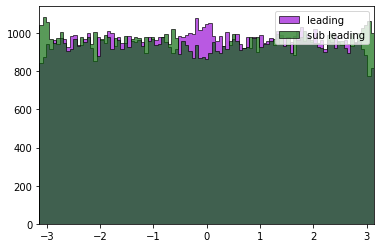

In [50]:
phi_bins = np.linspace(-np.pi,np.pi,100,endpoint=True)

plt.hist(X[:,3], bins=phi_bins, label='leading', alpha=.65, color='darkviolet',
        edgecolor='black', histtype='stepfilled')
plt.hist(X[:,7], bins=phi_bins, label='sub leading', alpha=.65,
         color='darkgreen', edgecolor='black', histtype='stepfilled')
plt.xlim(np.min(phi_bins), np.max(phi_bins))
plt.legend()
plt.show()

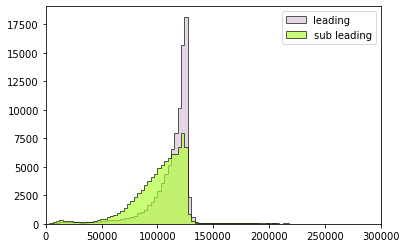

In [58]:
target_bins = np.linspace(0,3e5,100,endpoint=True)

plt.hist(Y[:,0], bins=target_bins, label='leading', alpha=.65, color='thistle',
        edgecolor='black', histtype='stepfilled')
plt.hist(Y[:,1], bins=target_bins, label='sub leading', alpha=.65,
         color='greenyellow', edgecolor='black', histtype='stepfilled')
plt.xlim(np.min(target_bins), np.max(target_bins))
plt.legend()
plt.show()

## Normalized

In [60]:
Yn = np.empty(Y.shape)
Xn = np.empty(X.shape)

### Target

In [67]:
Yn = (Y - 1e5) / 1e5

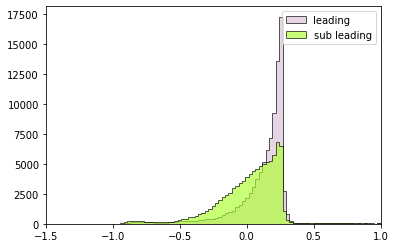

In [68]:
targetn_bins = np.linspace(-1.5,1,100,endpoint=True)

plt.hist(Yn[:,0], bins=targetn_bins, label='leading', alpha=.65, color='thistle',
        edgecolor='black', histtype='stepfilled')
plt.hist(Yn[:,1], bins=targetn_bins, label='sub leading', alpha=.65,
         color='greenyellow', edgecolor='black', histtype='stepfilled')
plt.xlim(np.min(targetn_bins), np.max(targetn_bins))
plt.legend()
plt.show()

### Inputs

In [69]:
Xn[:,0] = (X[:,0] - 100) / 1e2
Xn[:,4] = (X[:,4] - 100) / 1e2

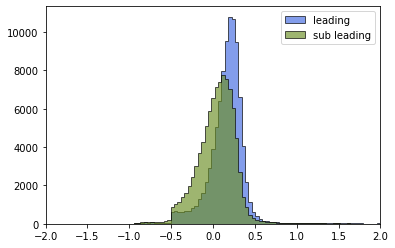

In [71]:
massn_bins = np.linspace(-2,2,100,endpoint=True)

plt.hist(Xn[:,0], bins=massn_bins, label='leading', alpha=.65, color='royalblue',
        edgecolor='black', histtype='stepfilled')
plt.hist(Xn[:,4], bins=massn_bins, label='sub leading', alpha=.65,
         color='olivedrab', edgecolor='black', histtype='stepfilled')
plt.xlim(np.min(massn_bins), np.max(massn_bins))
plt.legend()
plt.show()

In [72]:
pt_av = ( np.mean(np.log(X[:,1])) + np.mean(np.log(X[:,5])) ) /2
pt_std = ( np.std(np.log(X[:,1])) + np.std(np.log(X[:,5])) ) /2
print('pt average: {}'.format(pt_av))
print('pt_std: {}'.format(pt_std))

Xn[:,1] = (np.log(X[:,1]) - pt_av) / pt_std
Xn[:,5] = (np.log(X[:,5]) - pt_av) / pt_std

pt average: 6.288599983163265
pt_std: 0.39843910930253384


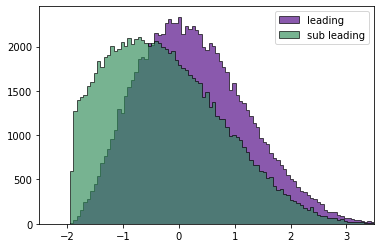

In [83]:
logPtn_bins = np.linspace(-2.5,3.5,100,endpoint=True)

plt.hist(Xn[:,1], bins=logPtn_bins, label='leading', alpha=.65, color='indigo',
        edgecolor='black', histtype='stepfilled')
plt.hist(Xn[:,5], bins=logPtn_bins, label='sub leading', alpha=.65,
         color='seagreen', edgecolor='black', histtype='stepfilled')
plt.xlim(np.min(logPtn_bins), np.max(logPtn_bins))
plt.legend()
plt.show()

In [77]:
eta_av = ( np.mean(X[:,2]) + np.mean(X[:,6]) ) /2
eta_std = ( np.std(X[:,2]) + np.std(X[:,6]) ) /2
print('eta average: {}'.format(eta_av))
print('eta_std: {}'.format(eta_std))

Xn[:,2] = X[:,2] / eta_std
Xn[:,6] = X[:,6] / eta_std

eta average: -0.0009072141019247392
eta_std: 0.8337986058000857


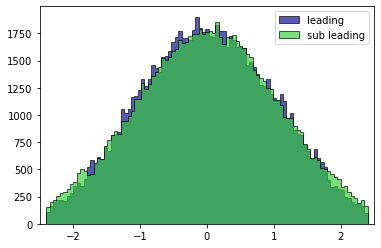

In [82]:
etan_bins = np.linspace(-2.5,2.5,100,endpoint=True)

plt.hist(Xn[:,2], bins=etan_bins, label='leading', alpha=.65, color='darkblue',
        edgecolor='black', histtype='stepfilled')
plt.hist(Xn[:,6], bins=etan_bins, label='sub leading', alpha=.65,
         color='limegreen', edgecolor='black', histtype='stepfilled')
plt.xlim(np.min(etan_bins), np.max(etan_bins))
plt.legend()
plt.show()

In [79]:
Xn[:,3] = X[:,3] / 3
Xn[:,7] = X[:,7] / 3

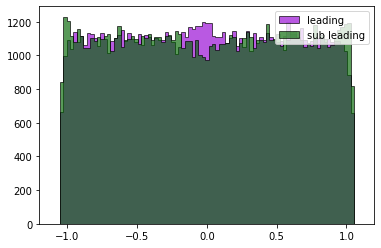

In [81]:
phin_bins = np.linspace(-1.2,1.2,100,endpoint=True)

plt.hist(Xn[:,3], bins=phin_bins, label='leading', alpha=.65, color='darkviolet',
        edgecolor='black', histtype='stepfilled')
plt.hist(Xn[:,7], bins=phin_bins, label='sub leading', alpha=.65,
         color='darkgreen', edgecolor='black', histtype='stepfilled')
plt.xlim(np.min(phin_bins), np.max(phin_bins))
plt.legend()
plt.show()

# Properly Train Network

In [96]:
base_model = Dumb_Network(num_features=8, name='baseline_DNN')
base_model.compile(loss='mse', optimizer=keras.optimizers.Adam(
    learning_rate=.002))
base_model.summary()

Model: "baseline_DNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 8)]               0         
_________________________________________________________________
dense_0 (Dense)              (None, 100)               900       
_________________________________________________________________
activation_0 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_2 (Activation)    (None, 100)              

In [97]:
dnn_history = base_model.fit(Xn,
              Yn,
              epochs=100,
              batch_size=6000)

Epoch 1/100
16/16 [==============================] - 0s 3ms/step - loss: 0.0624
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 0.0366
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 0.0329
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 0.0320
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 0.0315
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.0311
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.0310
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.0307
Epoch 9/100
16/16 [==============================] - 0s 3ms/step - loss: 0.0305
Epoch 10/100
16/16 [==============================] - 0s 4ms/step - loss: 0.0303
Epoch 11/100
16/16 [==============================] - 0s 3ms/step - loss: 0.0301
Epoch 12/100
16/16 [==============================] - 0s 3ms/step - loss: 0.0299
Epoch 13/100
16/16 [=================

<class 'keras.callbacks.History'>
dict_keys(['loss'])


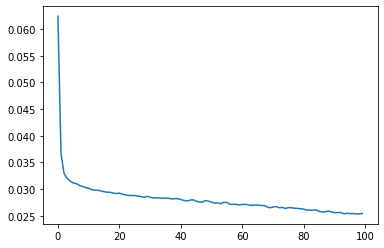

In [98]:
print(type(dnn_history))
print(dnn_history.history.keys())

plt.plot(dnn_history.history['loss'])
plt.show()

### Notes:
 - okay so the network is clearly learning to optimize something here despite minimal information
 
### Next steps:
 - [ ] Split data into training and validation to see where overtraining is happening

## Mass Plane

In [ ]:
mp_range = [[5e4], [1.5e5]]

plt.hist2d(x=Y[:,0], y=Y[:,1], bins=10, range=mp_range,
                         density=False, weights=None, cmin=None, cmax=None)
plt.show()